Ноутбук по проекту chicago_spark.  
Агрегация данных по гео-ключам (районы, округа) и временным промежуткам

## Импорты

In [1]:
import os
import sys

In [2]:
import pandas as pd
from scipy import stats
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [3]:
from importlib import reload
import time
from tqdm import tqdm
from functools import reduce
from itertools import islice

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, HTML

In [5]:
from enviserv.dictan import DictAnalyzer # анализ словарей
import pandserv as pds # форматирование небольших пандас ДФ

In [6]:
from sparkserv import SparkApp, Cols
# в SparkApp упакованы функции создания спарк приложения 
# с определением IP мастер-ноды и с подключением к кластеру

# Col - класс для формирования коротких псевдонимов имен столбцов
# при этом исходные имена полей не меняются

In [7]:
import pyspark.sql.functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, LongType
from pyspark.sql.window import Window
from pyspark.sql import Row

In [8]:
# гео библиотеки
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point

## Создание сессии, загрузка данных

In [9]:
spark_app = SparkApp(my_logger_create_level = 'INFO')

INFO:spark_app:spark_master_ip: 172.18.0.2
INFO:spark_app:pyspark version: 3.4.1
INFO:spark_app:starting building spark app object: pyspark-taxi-forecasting
INFO:spark_app:Spark app object built as: <pyspark.sql.session.SparkSession object at 0x7f46615de8d0>
INFO:spark_app:==================================================================
INFO:spark_app:Spark object can be accessed as the SparkApp_object.spark property
INFO:spark_app:==================================================================


In [10]:
spark_master_ip = spark_app.get_spark_master_ip()
# print(spark_master_ip)

INFO:spark_app:spark_master_ip: 172.18.0.2


In [11]:
# spark = spark_app.build_spark_app(spark_master_ip=spark_master_ip)
# spark = spark_app.spark

Для корректного завершения спарк-сессии (например, для переключения между ноутбуками) следует останавливать сессию полностью. Для этого использую метод .stop_spark_app() класса SparkApp

In [12]:
# spark_app.stop_spark_app()

In [13]:
print(spark_app.spark)

In [14]:
spark_app.build_spark_app()

INFO:spark_app:pyspark version: 3.4.1
INFO:spark_app:starting building spark app object: pyspark-taxi-forecasting
INFO:spark_app:Spark app object built as: <pyspark.sql.session.SparkSession object at 0x7f46615de8d0>
INFO:spark_app:==================================================================
INFO:spark_app:Spark object can be accessed as the SparkApp_object.spark property
INFO:spark_app:==================================================================


Получим стандартный объект `spark` из созданного выше объекта `spark_app`

In [15]:
spark = spark_app.spark

Проверка работы спарк-объекта на кластере. Если все в порядке, то тест должен выполниться достаточно быстро и отобразить тестовый ДФ.  
```txt
+------------+-----------+
|student_name|student_age|
+------------+-----------+
|       Alice|         10|
|         Bob|         20|
+------------+-----------+
```

Если исходные образы кластера собраны с ошибкой, возможно "зависание" работы теста.

In [16]:
spark_app.test_spark_functionality()

Spark session created successfully.
DataFrame created successfully.
Alias DataFrame created successfully.
DataFrame data matches expected result.
+------------+-----------+
|student_name|student_age|
+------------+-----------+
|       Alice|         10|
|         Bob|         20|
+------------+-----------+

DataFrame show output matches expected output.

=======use======================
*      ____              __    *
*     / __/__  ___ _____/ /__  *
*    _\ \/ _ \/ _ `/ __/  '_/  *
*   /__ / .__/\_,_/_/ /_/\_\   *
*      /_/                     * 
        


## Загрузка и описание данных

Первичное исследование датасета проведено в ноутбуке eda_... 

Загрузим очищенные данные. В интерфейсе Докера должно отображаться увеличение загрузки по всем воркерам (почти до 100%). Также можно увидеть рост загрузки на ядрах-потоках процессора, выделенных под кластер.

In [17]:
%%time
taxis = spark.read.load('/work/data/taxis_r.csv', 
                       format='csv', header='true'
                        , inferSchema='true'
                       )

CPU times: user 43.7 ms, sys: 26.4 ms, total: 70.1 ms
Wall time: 2min 22s


In [18]:
taxis.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: timestamp (nullable = true)
 |-- Trip End Timestamp: timestamp (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Cen

In [19]:
# создадим объект для представления имен полей
ct = Cols(taxis)
ct.get_aliases()

{'trip_i': 'Trip ID',
 'taxi_i': 'Taxi ID',
 'trip_st': 'Trip Start Timestamp',
 'trip_et': 'Trip End Timestamp',
 'trip_s': 'Trip Seconds',
 'trip_m': 'Trip Miles',
 'pickup_ct': 'Pickup Census Tract',
 'dropoff_ct': 'Dropoff Census Tract',
 'pickup_ca': 'Pickup Community Area',
 'dropoff_ca': 'Dropoff Community Area',
 'fare': 'Fare',
 'tips': 'Tips',
 'tolls': 'Tolls',
 'extras': 'Extras',
 'trip_t': 'Trip Total',
 'payment_t': 'Payment Type',
 'company': 'Company',
 'pickup_cl': 'Pickup Centroid Latitude',
 'pickup_clon': 'Pickup Centroid Longitude',
 'pickup_cloc': 'Pickup Centroid Location',
 'dropoff_cl': 'Dropoff Centroid Latitude',
 'dropoff_clon': 'Dropoff Centroid Longitude',
 'dropoff_cloc': 'Dropoff Centroid  Location'}

In [20]:
# %%time
# # код ячейки закомментирован, т.к. описание данных
# # уже сохранено во внешнейм файле
# # но при необходимости пересчитать статистики
# # код надо раскомментировать
# # CPU times: user 438 ms, sys: 335 ms, total: 773 ms
# # Wall time: 13min 28s

# tdd_res = taxis.summary().toPandas()

In [21]:
# output_file_path = '/work/data/all_summary_result.csv'
# tdd_res.to_csv(output_file_path, index=False)

In [22]:
tdd_res = pd.read_csv('/work/data/all_summary_result.csv',sep=',',index_col='summary')

In [23]:
drf = tdd_res.copy()
#  отформатируем таблицу описания
pds.get_df_formated(drf, '`',2, 10)

In [24]:
drf.transpose()

summary                          count               mean            stddev  \
Trip ID                     18`706`059                nan               nan   
Taxi ID                     18`706`059                nan               nan   
Trip Seconds                18`706`059           1`162.53            945.77   
Trip Miles                  18`706`059               6.19              6.88   
Pickup Census Tract         18`706`059  15`529`758`274.25  2`383`702`696.58   
Dropoff Census Tract        18`706`059  15`259`197`121.54  2`483`394`317.93   
Pickup Community Area       18`706`059              35.42             27.04   
Dropoff Community Area      18`706`059              30.61             26.28   
Fare                        18`706`059              21.22             16.48   
Tips                        18`706`059               2.68              4.01   
Tolls                       18`706`059               0.01              0.50   
Extras                      18`706`059               1.93              5.37   
Trip Total                  18`706`059              25.83             21.54   
Payment Type                18`706`059                nan               nan   
Company                     18`706`059                nan               nan   
Pickup Centroid Latitude    18`198`158              41.90              0.06   
Pickup Centroid Longitude   18`198`158             -87.69              0.11   
Pickup Centroid Location    18`198`158                nan               nan   
Dropoff Centroid Latitude   17`491`750              41.89              0.06   
Dropoff Centroid Longitude  17`491`750             -87.66              0.07   
Dropoff Centroid  Location  17`491`750                nan               nan   

summary                                min             25%             50%  \
Trip ID                         0000000c78             nan             nan   
Taxi ID                         0041f8f0c9             nan             nan   
Trip Seconds                             0             468             898   
Trip Miles                               0            0.89            2.70   
Pickup Census Tract         10`000`000`000  12`000`000`036  17`031`081`403   
Dropoff Census Tract        11`000`000`000  12`000`000`036  17`031`081`500   
Pickup Community Area                    1               8              32   
Dropoff Community Area                   1               8              28   
Fare                                     0               8           14.25   
Tips                                     0               0               0   
Tolls                                    0               0               0   
Extras                                   0               0               0   
Trip Total                               0            9.75           17.06   
Payment Type                          Cash             nan             nan   
Company                         24 Seven T             nan             nan   
Pickup Centroid Latitude             41.65           41.88           41.90   
Pickup Centroid Longitude           -87.91          -87.71          -87.64   
Pickup Centroid Location        POINT (-87             nan             nan   
Dropoff Centroid Latitude            41.65           41.88           41.89   
Dropoff Centroid Longitude          -87.91          -87.66          -87.63   
Dropoff Centroid  Location      POINT (-87             nan             nan   

summary                                75%             max  
Trip ID                                nan      ffffffdda8  
Taxi ID                                nan      fff84aa08a  
Trip Seconds                         1`655           7`900  
Trip Miles                           11.15              53  
Pickup Census Tract         17`031`320`100  17`031`980`100  
Dropoff Census Tract        17`031`320`100  17`031`980`100  
Pickup Community Area                   56              91  
Dropoff Community Area                  35              

Загрузим ранее сохраненный файл с описанием полей ДФ такси

In [25]:
pd.set_option('display.max_colwidth', None)

table_descr = pd.read_csv('/work/data/table_descr.csv',sep=';',index_col='Column Name')
display(table_descr)

pd.reset_option('display.max_colwidth')  # Сброс максимальной ширины столбцов к значению по умолчанию

Description  \
Column Name                                                                                                                                                                                                                 
Trip ID                                                                                                                                                                                 A unique identifier for the trip.   
Taxi ID                                                                                                                                                                                 A unique identifier for the taxi.   
Trip Start Timestamp                                                                                                                                             When the trip started rounded to the nearest 15 minutes.   
Trip End Timestamp                                                                                                                                                 When the trip ended rounded to the nearest 15 minutes.   
Trip Seconds                                                                                                                                                                                 Time of the trip in seconds.   
Trip Miles                                                                                                                                                                                 Distance of the trip in miles.   
Pickup Census Tract                                     The Census Tract where the trip began. For privacy  this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago.   
Dropoff Census Tract                                    The Census Tract where the trip ended. For privacy  this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago.   
Pickup Community Area                                                                                                   The Community Area where the trip began. This column will be blank for locations outside Chicago.   
Dropoff Community Area                                                                                                  The Community Area where the trip ended. This column will be blank for locations outside Chicago.   
Fare                                                                                                                                                                                               The fare for the trip.   
Tips                                                                                                                                                      The tip for the trip. Cash tips generally will not be recorded.   
Tolls                                                                                                                                                                                             The tolls for the trip.   
Extras                                                                                                                                                                                        Extra charges for the trip.   
Trip Total                                                                                                                                                      Total cost of the trip the total of the previous columns.   
Payment Type                                                                                                                                                                                Type of payment for the trip.   
Company                                                                                                                                                                                                 The taxi company.   
Pickup 

### Описание полей "Census Tract" и "Community Area"

Поля "Census Tract" и "Community Area" представляют собой два различных уровня административных единиц:

**Census Tract:**  
Это статистические единицы, используемые в переписи населения в США, проводимой каждые 10 лет.
Census Tract обычно представляют собой географические области, населенные от 1 200 до 8 000 человек.
Они предназначены для обеспечения стандартизированных данных для анализа населения, доходов, расового и этнического состава и других социально-экономических параметров.

Далее для краткости буду называть данную адм.единицу - **Район** (хотя правильней было бы "квартал", но этот термин будет путаться с временным окном)

**Community Area:**  
Это административные районы в городе Чикаго, разработанные городским правительством.
Community Areas используются для организации и управления городскими службами и ресурсами.
Обычно Community Areas выступают в качестве единиц анализа для изучения социальных и экономических показателей, таких как уровень преступности, доступность образования и здравоохранения и др.

Далее для краткости буду называть данную адм.единицу - **Округ**

Community Area представляют собой административные районы, охватывающие большие части города, в то время как Census Tract более мелкие географические области, которые могут быть распределены по всему Community Area. Таким образом, Community Area охватывает несколько Census Tract и представляет собой более крупную административную единицу.

В идеальной ситуации каждый Census Tract должен быть частью только одной Community Area, чтобы избежать перекрытий и дублирования данных. Однако в реальности могут быть исключения из-за изменений границ административных районов или других факторов.

### Ключи-агрегаторы

В качестве ключа-агрегатора будет использоваться район - для детальной агрегации и округ для крупной (как и требуется в рамках проекта)

## Инвентаризация объектов

In [26]:
# reload(pds)

Посмотрим список объектов в памяти области видимости программы

In [27]:
# Вызов функций
df_inventory = pds.inventory_objects()
pds.display_chunked(df_inventory, chunk_size=10)

Displaying rows 0 to 8 of 9


Больших объектов по занимаемой памяти нет. Пока ничего удалять не будем.

## Частоты "Census Tract"

Посмотрим распределение трактов с координатами

In [21]:
ct_p =  taxis.select(
    f.col(ct.pickup_ct).alias("ct"),
    f.col(ct.pickup_cl).alias("lat"),
    f.col(ct.pickup_clon).alias("lon"),
).filter(
    (f.col("ct").isNotNull()) &
    (f.col("lat").isNotNull()) &
    (f.col("lon").isNotNull())
).groupBy("ct","lat","lon").count().orderBy(f.col("count").desc())

# ct_null_p.cache()

ct_d =  taxis.select(
    f.col(ct.dropoff_ct).alias("ct"),
    f.col(ct.dropoff_cl).alias("lat"),
    f.col(ct.dropoff_clon).alias("lon")
).filter(
    (f.col("ct").isNotNull()) &
    (f.col("lat").isNotNull()) &
    (f.col("lon").isNotNull())
).groupBy("ct","lat","lon").count().orderBy(f.col("count").desc())
# taxisd.cache()


In [22]:
print("Количество пунктов посадки с координатами:",ct_p.count())
ct_p.show(20)
ct_p.cache()
print("Количество пунктов высадки с координатами:",ct_d.count())
ct_d.show(20)
ct_d.cache()

Количество пунктов посадки с координатами: 748
+-----------+------------+-------------+-------+
|         ct|         lat|          lon|  count|
+-----------+------------+-------------+-------+
|12000000036|41.899602111|-87.633308037|2071762|
|17031010702|41.980264315|-87.913624596|1719391|
|17031980000| 41.97907082|-87.903039661|1679290|
|17031120200|41.878865584|-87.625192142| 958456|
|17031320100|41.884987192|-87.620992913| 870839|
|17031839100|41.880994471|-87.632746489| 839637|
|17031030500|41.874005383| -87.66351755| 814221|
|17031090200|41.944226601|-87.655998182| 636011|
|17031281900|41.879255084|-87.642648998| 600877|
|17031081500|41.892507781|-87.626214906| 493449|
|17031242200|41.922686284|-87.649488729| 392383|
|12000000016| 41.79259236|-87.769615453| 353893|
|17031081401| 41.89503345|-87.619710672| 326412|
|17031081403|41.890922026|-87.618868355| 304083|
|12000000010| 41.96581197|-87.655878786| 299841|
|17031330100|41.859349715|-87.617358006| 293857|
|17031980100|41.785998

DataFrame[ct: bigint, lat: double, lon: double, count: bigint]

Создадим функцию для вывода 3Д гистграмм

In [23]:
def plot_3d_hist(pdf):
    # Настройка размерности гистограммы
    x_bins = np.linspace(pdf['lon'].min(), pdf['lon'].max(), num=30)
    y_bins = np.linspace(pdf['lat'].min(), pdf['lat'].max(), num=30)
    
    # Создание гистограммы
    hist, x_edges, y_edges = np.histogram2d(pdf['lon'], pdf['lat'], bins=[x_bins, y_bins], weights=pdf['count'])
    
    # Создание 3D графика
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Создание координат для гистограммы
    x_pos, y_pos = np.meshgrid(x_edges[:-1] + 0.25, y_edges[:-1] + 0.25, indexing="ij")
    x_pos = x_pos.ravel()
    y_pos = y_pos.ravel()
    z_pos = 0
    
    # Размеры гистограммы
    dx = dy = 0.012 * np.ones_like(z_pos)  # Уменьшаем толщину столбцов
    dz = hist.ravel()
    
    # Построение гистограммы
    ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, zsort='average')
    
    # Настройка меток осей
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Number of Trips')
    
    # Отображение графика
    plt.show()

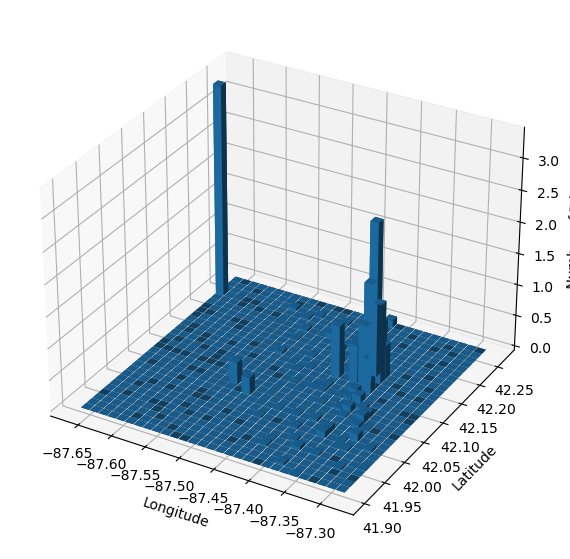

In [24]:
plot_3d_hist(ct_p.toPandas())

Видим, что самая плотная точка посадки находится на северо-западе (41.899602111|-87.633308037|673'556). Очевидно - это аэропорт О'Хара. 
Другие плотные точки находятся в центре города.  
Посмотрим график для точек с количеством поездок менее 200К

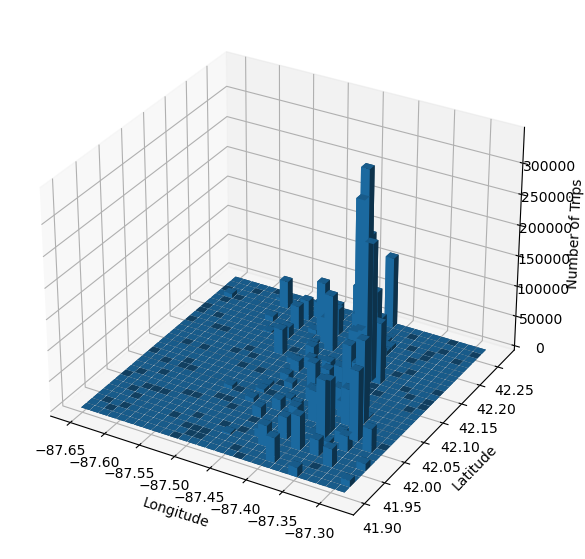

In [25]:
plot_3d_hist(ct_p.filter(f.col("count")<200000).toPandas())

Наиболее плотные области также в центре - вдоль озера.  
Посмотрим на точки высадки

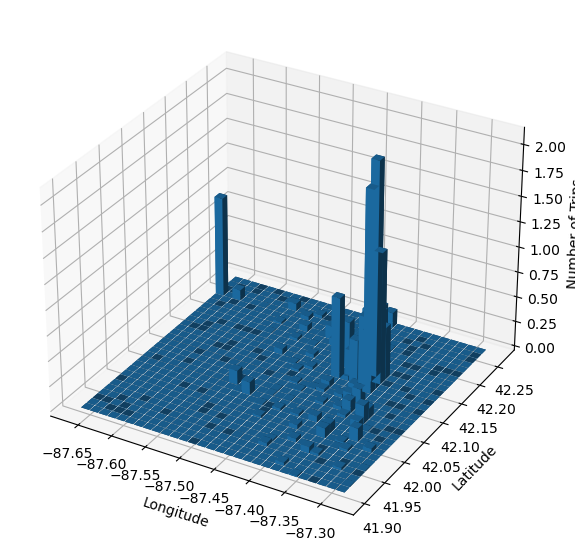

In [26]:
plot_3d_hist(ct_d.toPandas())

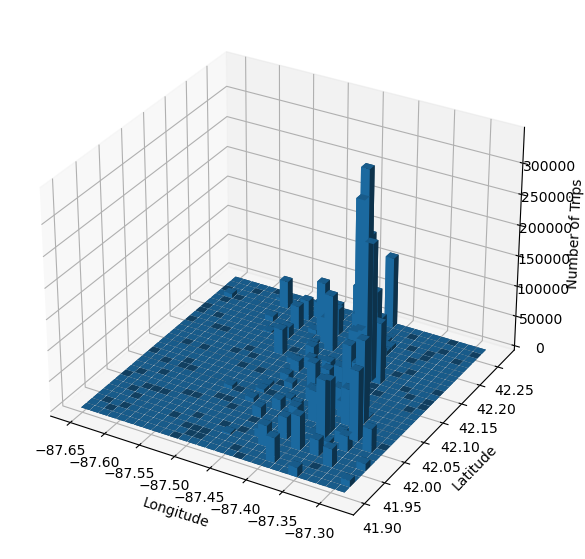

In [27]:
plot_3d_hist(ct_p.filter(f.col("count")<200000).toPandas())

Плотность точек высадки имеет схожую картину. Но аэропорт не лидирует.  

Основные выводы  
- следует отдельно анализировать поездки из аэропорта (и в аэропорт)
- основная часть поездок совершается по центральным районам

## Обзор полей 'Payment Type', 'Company'

Посмотрим типы платежей

In [20]:
payment_types = taxis.select(f.col(ct.payment_t))\
.groupBy(f.col(ct.payment_t)).count().orderBy(f.col("count").desc()).toPandas()

In [21]:
payment_types.set_index(['Payment Type'], inplace=True)

In [22]:
pt = payment_types.copy()
pt_total = pt['count'].sum()
pt['pt_ratio']=(pt['count']/pt_total)*100
# f"Доля таких записей в датасете: {(key_full_null_count/row_count)*100:.2f}%"

In [23]:
#  отформатируем таблицу
pds.get_df_formated(pt, '\'',2, 10)
pt

count pt_ratio
Payment Type                    
Credit Card   7'122'369    38.08
Cash          6'004'118    32.10
Mobile        2'552'494    13.65
Prcard        1'969'606    10.53
Unknown       1'057'472     5.65

Посмотрим компании

In [28]:
companies = taxis.select(f.col(ct.company))\
.groupBy(f.col(ct.company)).count().orderBy(f.col("count").desc()).toPandas()

In [29]:
companies.set_index([ct.company], inplace=True)

In [30]:
cmps = companies.copy()
cmps_total = cmps['count'].sum()
cmps['company_ratio']=(cmps['count']/cmps_total)*100

In [31]:
#  отформатируем таблицу
pds.get_df_formated(cmps, '\'',2, 10)
cmps['company_ratio'] = cmps['company_ratio'].astype(float)
print("Количество компаний:",cmps['count'].count())
cmps

Количество компаний: 24


count  company_ratio
Company                                                       
Flash Cab                             4'180'032          22.35
Taxi Affiliation Services             4'025'763          21.52
Sun Taxi                              1'971'056          10.54
City Service                          1'681'173           8.99
Taxicab Insurance Agency Llc          1'158'224           6.19
Chicago Independents                    911'009           4.87
Medallion Leasin                        776'334           4.15
Globe Taxi                              661'826           3.54
Taxicab Insurance Agency, LLC           617'510           3.30
5 Star Taxi                             546'435           2.92
Blue Ribbon Taxi Association            442'092           2.36
Star North Taxi Management Llc          298'848           1.60
Choice Taxi Association                 275'090           1.47
Top Cab Affiliation                     205'932           1.10
Less02                                  192'433           1.03
U Taxicab                               160'046           0.86
Blue Ribbon Taxi Association Inc.       148'242           0.79
24 Seven Taxi                           105'880           0.57
Patriot Taxi Dba Peace Taxi Associat     68'488           0.37
Chicago City Taxi Association            64'517           0.34
Choice Taxi Association Inc              62'849           0.34
Star North Management LLC                59'088           0.32
Chicago Taxicab                          54'534           0.29
Koam Taxi Association                    38'658           0.21

## Агрегация

Сделаем агрегацию по четвертьчасовым периодам.  
Создадим 2 агрегированных ДФ:
- по районам (округам) посадки, без включения полей с гео-ключами высадки
- по районам (округам) высадки, без включения полей с гео-ключами посадки

Создадим такие поля:
- район (тракт): `tract`
- округ (ареа): `area`
- начало интервала: `interbeg`
- конец интервала: `interend`
- количество поездок: `trips`
- общая длительность поездок: `time`
- общее расстояние поездок: `miles`
- средняя скорость поездок: `velocity` = `miles`/`time`
- суммы стоимостей: `fare`,`tips`,`tolls`,`extras`,`total`
- стоимости на расстояние: `farem`,`tipsm`,`tollsm`,`extrasm`,`totalm`
- стоимости на время: `fares`,`tipss`,`tollss`,`extrass`,`totals`
- тип платежа не включаю в рассмотрение
- доля заказов по каждой из 5 крупнейший компаний (с долей от 5% и выше): `comp1`,`comp2`,`comp3`,`comp4`,`comp5`
- общая доля заказов по компаниям с долей от 5% и ниже: `compless5`

In [32]:
# ct.get_aliases()

In [33]:
# Ф-я для разбиения на четвертьчасовые интервалы
def truncate_to_quarter_hour(timestamp_col):
    return (f.floor(f.unix_timestamp(timestamp_col) / 900) * 900).cast("timestamp")

# def truncate_to_quarter_hour_upper(timestamp_col):
#     return (f.floor((f.unix_timestamp(timestamp_col) + 899) / 900) * 900).cast("timestamp")

In [69]:
# Добавим интервалы
taxis = taxis.withColumn("interbeg_p", truncate_to_quarter_hour("Trip Start Timestamp"))
taxis = taxis.withColumn(
    "interend_p",
    f.from_unixtime(f.unix_timestamp("interbeg_p") + 15 * 60)
)

Интервалы для высадки считаем по времени окончании поездки

In [70]:
taxis = taxis.withColumn("interbeg_d", truncate_to_quarter_hour("Trip End Timestamp"))
taxis = taxis.withColumn(
    "interend_d",
    f.from_unixtime(f.unix_timestamp("interbeg_d") + 15 * 60 * 60)
)

In [ ]:
# interbegs_pick = taxis.select("interbeg_d").distinct()
# interbegs_drop = taxis.select("interbeg_d").distinct()

In [ ]:
# print(interbegs_pick.count())
# interbegs_pick.cache()
# interbegs_pick.show(10)
# print(interbegs_drop.count())
# interbegs_drop.cache()
# interbegs_drop.show(10)

In [36]:
# список топ команий с индивидуальной общей долей более 5%
top_companies = cmps[cmps['company_ratio'] >= 5.0].index.tolist()

In [43]:
# создадим выражение для группировки: доля каждой топ-компании в агрегации
def comp_expr(suffix=''):
    comp_exprs = [
        f.expr(f"sum(case when Company = '{company}' then 1 else 0 end) / count(*)")\
        .alias(f"comp{idx + 1}{suffix}")
        for idx, company in enumerate(top_companies)
    ]
    
    # общая доля компаний < 5% в агрегации
    comp_less5_expr = f.expr(
        "sum(case when Company NOT IN ({}) then 1 else 0 end) / count(*)".format(
            ", ".join([f"'{company}'" for company in top_companies])
        )
    ).alias(f"compless5{suffix}")
    
    # List of all expressions
    all_comp_exprs = comp_exprs + [comp_less5_expr]
    return all_comp_exprs

In [44]:
# Ф-я агрегации
def agg_func(pickup_or_dropoff):
    if pickup_or_dropoff == 'pickup':
        tract_col, area_col, interbeg, interend = \
        ct.pickup_ct, ct.pickup_ca, 'interbeg_p', 'interend_p'
        suffix = '_p'
    else:
        tract_col, area_col, interbeg, interend = \
        ct.dropoff_ct, ct.dropoff_ca, 'interbeg_d', 'interend_d'
        suffix = '_d'


    all_comp_exprs = comp_expr(suffix)

    return (taxis.groupBy(
        f.col(tract_col).alias(f"ct{suffix}"),
        f.col(area_col).alias(f"ca{suffix}"),
        interbeg, interend)
                .agg(
                     f.count("*").alias(f"trips{suffix}"),
                     f.sum("Trip Seconds").alias(f"time{suffix}"),
                     f.sum("Trip Miles").alias(f"miles{suffix}"),
                     f.when(f.sum("Trip Seconds") != 0, f.sum("Trip Miles") / f.sum("Trip Seconds")).otherwise(0).alias(f"velocity{suffix}"),
                     f.sum("Fare").alias(f"fare{suffix}"),
                     f.sum("Tips").alias(f"tips{suffix}"),
                     f.sum("Tolls").alias(f"tolls{suffix}"),
                     f.sum("Extras").alias(f"extras{suffix}"),
                     f.sum("Trip Total").alias(f"total{suffix}"),
                     f.when(f.sum("Trip Miles") != 0,
                            f.sum("Fare") / f.sum("Trip Miles")).otherwise(0).alias(f"farem{suffix}"),
                     f.when(f.sum("Trip Miles") != 0,
                            f.sum("Tips") / f.sum("Trip Miles")).otherwise(0).alias(f"tipsm{suffix}"),
                     f.when(f.sum("Trip Miles") != 0,
                            f.sum("Tolls") / f.sum("Trip Miles")).otherwise(0).alias(f"tollsm{suffix}"),
                     f.when(f.sum("Trip Miles") != 0,
                            f.sum("Extras") / f.sum("Trip Miles")).otherwise(0).alias(f"extrasm{suffix}"),
                     f.when(f.sum("Trip Miles") != 0,
                            f.sum("Trip Total") / f.sum("Trip Miles")).otherwise(0).alias(f"totalm{suffix}"),
                     f.when(f.sum("Trip Seconds") != 0,
                            f.sum("Fare") / f.sum("Trip Seconds")).otherwise(0).alias(f"fares{suffix}"),
                     f.when(f.sum("Trip Seconds") != 0,
                            f.sum("Tips") / f.sum("Trip Seconds")).otherwise(0).alias(f"tipss{suffix}"),
                     f.when(f.sum("Trip Seconds") != 0,
                            f.sum("Tolls") / f.sum("Trip Seconds")).otherwise(0).alias(f"tollss{suffix}"),
                     f.when(f.sum("Trip Seconds") != 0,
                            f.sum("Extras") / f.sum("Trip Seconds")).otherwise(0).alias(f"extrass{suffix}"),
                     f.when(f.sum("Trip Seconds") != 0,
                            f.sum("Trip Total") / f.sum("Trip Seconds")).otherwise(0).alias(f"totals{suffix}"),
                    *all_comp_exprs
                ))
    

In [71]:
# Aggregate by pickup census tract
pickup_agg = agg_func('pickup')

In [72]:
# Aggregate by dropoff community area
dropoff_agg = agg_func('dropoff')

In [73]:
pickup_agg.printSchema()

root
 |-- ct_p: long (nullable = true)
 |-- ca_p: integer (nullable = true)
 |-- interbeg_p: timestamp (nullable = true)
 |-- interend_p: string (nullable = true)
 |-- trips_p: long (nullable = false)
 |-- time_p: long (nullable = true)
 |-- miles_p: double (nullable = true)
 |-- velocity_p: double (nullable = true)
 |-- fare_p: double (nullable = true)
 |-- tips_p: double (nullable = true)
 |-- tolls_p: double (nullable = true)
 |-- extras_p: double (nullable = true)
 |-- total_p: double (nullable = true)
 |-- farem_p: double (nullable = true)
 |-- tipsm_p: double (nullable = true)
 |-- tollsm_p: double (nullable = true)
 |-- extrasm_p: double (nullable = true)
 |-- totalm_p: double (nullable = true)
 |-- fares_p: double (nullable = true)
 |-- tipss_p: double (nullable = true)
 |-- tollss_p: double (nullable = true)
 |-- extrass_p: double (nullable = true)
 |-- totals_p: double (nullable = true)
 |-- comp1_p: double (nullable = true)
 |-- comp2_p: double (nullable = true)
 |-- comp3_p

Очевидно в датафреймах есть пробелы в интервалах.
Создадим дф df_intervals с ровным рядом интервалов потом к нему лефт джойном присоедини _df_agg для каждого _Census Tract.

In [74]:
agg_results = taxis.agg(
    f.min("Trip Start Timestamp").alias("start_time_min"),
    f.max("Trip Start Timestamp").alias("start_time_max"),
    f.min("Trip End Timestamp").alias("end_time_min"),
    f.max("Trip End Timestamp").alias("end_time_max"),
    f.min("interbeg_p").alias("interbeg_p_min"),
    f.max("interbeg_p").alias("interbeg_p_max"),
    f.min("interend_d").alias("interend_d_min"),
    f.max("interend_d").alias("interend_d_max")
).first()

# Извлечение результатов
start_time_min = agg_results['start_time_min']
start_time_max = agg_results['start_time_max']
end_time_min = agg_results['end_time_min']
end_time_max = agg_results['end_time_max']
interbeg_p_min = agg_results['interbeg_p_min']
interbeg_p_max = agg_results['interbeg_p_max']
interend_d_min = agg_results['interend_d_min']
interend_d_max = agg_results['interend_d_max']

print(f"Start time range: {start_time_min} to {start_time_max}")
print(f"End time range: {end_time_min} to {end_time_max}")
print(f"Interbeg_p time range: {interbeg_p_min} to {interbeg_p_max}")
print(f"Interend_d range: {interend_d_min} to {interend_d_max}")

Start time range: 2021-01-01 00:00:00 to 2024-06-01 00:00:00
End time range: 2021-01-01 00:00:00 to 2024-06-01 00:45:00
Interbeg_p time range: 2021-01-01 00:00:00 to 2024-06-01 00:00:00
Interend_d range: 2021-01-01 15:00:00 to 2024-06-01 15:45:00


In [75]:
intervals_p = pickup_agg.groupBy("ct_p","ca_p").agg(
    f.min("interbeg_p").alias("interbeg_p_min"),
    f.max("interbeg_p").alias("interbeg_p_max"),
    f.min("interend_p").alias("interend_p_min"),
    f.max("interend_p").alias("interend_p_max"),
    f.count("ct_p")
)

In [76]:
intervals_p.count()

749

In [77]:
intervals_p.show(5)

+-----------+----+-------------------+-------------------+-------------------+-------------------+-----------+
|       ct_p|ca_p|     interbeg_p_min|     interbeg_p_max|     interend_p_min|     interend_p_max|count(ct_p)|
+-----------+----+-------------------+-------------------+-------------------+-------------------+-----------+
|10000000000|  91|2021-01-01 00:00:00|2024-06-01 00:00:00|2021-01-01 00:15:00|2024-06-01 00:15:00|      95627|
|12000000001|  53|2021-01-01 07:15:00|2024-05-31 23:45:00|2021-01-01 07:30:00|2024-06-01 00:00:00|      31737|
|12000000002|  75|2021-01-01 00:30:00|2024-05-31 22:30:00|2021-01-01 00:45:00|2024-05-31 22:45:00|      27782|
|12000000003|  48|2021-01-01 08:00:00|2024-05-31 17:15:00|2021-01-01 08:15:00|2024-05-31 17:30:00|      21181|
|12000000004|  65|2021-01-01 08:00:00|2024-05-31 19:15:00|2021-01-01 08:15:00|2024-05-31 19:30:00|       6718|
+-----------+----+-------------------+-------------------+-------------------+-------------------+-----------+
o

In [78]:
intervals_p.cache()

DataFrame[ct_p: bigint, ca_p: int, interbeg_p_min: timestamp, interbeg_p_max: timestamp, interend_p_min: string, interend_p_max: string, count(ct_p): bigint]

In [ ]:
# Определим временные границы и шаг интервала в секундах
interval_step = 900  # 15 минут в секундах

# Преобразуем pandas DataFrame в Spark DataFrame
def generate_intervals(start_time, end_time, freq='15T'):
    date_range = pd.date_range(start=start_time, end=end_time, freq=freq)
    intervals = pd.DataFrame({'interbeg': date_range})
    intervals['interend'] = intervals['interbeg'] + pd.Timedelta(minutes=15)
    return spark.createDataFrame(intervals)

# Создаем пустой DataFrame для хранения всех интервалов
full_intervals_p = None

# Создаем интервалы для каждой пары ct_p и ca_p
for row in intervals_p.collect():
    ct_p = row['ct_p']
    ca_p = row['ca_p']
    interbeg_p_min = row['interbeg_p_min']
    interbeg_p_max = row['interbeg_p_max']
    
    # Генерируем интервалы
    df_intervals = generate_intervals(interbeg_p_min, interbeg_p_max)
    
    # Добавляем ct_p и ca_p к интервалам
    df_intervals = df_intervals.withColumn("ct_p", f.lit(ct_p)).withColumn("ca_p", f.lit(ca_p))
    
    # Объединяем интервалы для всех пар
    if full_intervals_p is None:
        full_intervals_p = df_intervals
    else:
        full_intervals_p = full_intervals_p.union(df_intervals)

In [ ]:
# Проверка полученного DataFrame
full_intervals_p.show(5)